THIS NOTEBOOK IS TO FIND IF PHYSICAL ATTRIBUTES OF A MALE SWIMMER HAS ANY EFFECT ON THIER CHANCE OF MEDAL WIN.

In [1]:
#!pip install imblearn
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from imblearn.combine import SMOTETomek
from sklearn import metrics
import imblearn
import collections
from imblearn.over_sampling import SMOTE

MERGING THE EVENTS AND REGIONS DATASET

In [2]:
events=pd.read_csv("/home/jovyan/athlete_events.csv") 
regions=pd.read_csv("/home/jovyan/noc_regions.csv")
olympics = pd.merge(events, regions, on="NOC", how="left") 
print(olympics.head(),olympics.shape)

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal       region notes  
0       Basketball Men's Basketball   NaN        China   NaN  
1      Judo Men's Extra-Lightwei

Filtering to only contain rows that correspond to Summer Olympics and also excluding year 1906 Intercaleted Games from the data. IN this game medals were distributed but are no longer recognized by the International Olympic Committee.

In [3]:
Summer_olympics=olympics[(olympics.Season=='Summer') & (olympics.Year!=1906)]

In [4]:
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 271110
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      220819 non-null  int64  
 1   Name    220819 non-null  object 
 2   Sex     220819 non-null  object 
 3   Age     212373 non-null  float64
 4   Height  170438 non-null  float64
 5   Weight  168493 non-null  float64
 6   Team    220819 non-null  object 
 7   NOC     220819 non-null  object 
 8   Games   220819 non-null  object 
 9   Year    220819 non-null  int64  
 10  Season  220819 non-null  object 
 11  City    220819 non-null  object 
 12  Sport   220819 non-null  object 
 13  Event   220819 non-null  object 
 14  Medal   33630 non-null   object 
 15  region  220449 non-null  object 
 16  notes   4361 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 30.3+ MB


In [5]:
# Descriptive Statistics
Summer_olympics.describe()
Summer_olympics.iloc[:,1:].describe()

,Age,Height,Weight,Year
count,212373.000000,170438.000000,168493.000000,220819.000000
mean,25.667288,175.511494,70.682699,1976.868947
std,6.692954,10.918801,14.805977,30.427978
min,10.000000,127.000000,25.000000,1896.000000
25%,21.000000,168.000000,60.000000,1960.000000
50%,24.000000,175.000000,70.000000,1984.000000
75%,28.000000,183.000000,79.000000,2000.000000
max,97.000000,226.000000,214.000000,2016.000000


In [6]:
## Data Split into Train and Test
data_test = Summer_olympics[Summer_olympics.Year==2016]
data_train = Summer_olympics[Summer_olympics.Year<2016]

#dropping columns ID, Games and notes
data_train = data_train.drop(data_train.columns[[0,8, 16]], axis=1)
data_test = data_test.drop(data_test.columns[[0,8, 16]], axis=1)



DATA IMPUTATION: During EXPLORATION, we observed genuine outliers for Varibales AGE,HEIGHT AND WEIGHT which cannot be replaced with mean or deleted as it might then defeat the whole purpose of using data of Olympians. so Imputation is done using median.

In [7]:
## filling the NaN values of column 'Region' by taking the values from 'Team' 
data_train["region"].fillna(data_train["Team"], inplace=True)

## imputing the Age,Height,weight using the median
import numpy as np
imp_col = ['Age','Height','Weight']
for col in imp_col:
    data_train[col] = data_train[col].fillna((data_train[col].median()))

In [8]:
print(data_train.isnull().sum())

Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     175524
region         0
dtype: int64


In [9]:
#lets create separate columns for gold,silver and bronnze using get_dummies method and add new column 'all medals', to represnt if any medal is won or not
new_data_train = pd.concat([data_train,pd.get_dummies(data_train.Medal)],axis=1)
new_data_train['allmedals']= new_data_train['Bronze']+new_data_train['Gold']+new_data_train['Silver']
new_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207131 entries, 0 to 271109
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Name       207131 non-null  object 
 1   Sex        207131 non-null  object 
 2   Age        207131 non-null  float64
 3   Height     207131 non-null  float64
 4   Weight     207131 non-null  float64
 5   Team       207131 non-null  object 
 6   NOC        207131 non-null  object 
 7   Year       207131 non-null  int64  
 8   Season     207131 non-null  object 
 9   City       207131 non-null  object 
 10  Sport      207131 non-null  object 
 11  Event      207131 non-null  object 
 12  Medal      31607 non-null   object 
 13  region     207131 non-null  object 
 14  Bronze     207131 non-null  uint8  
 15  Gold       207131 non-null  uint8  
 16  Silver     207131 non-null  uint8  
 17  allmedals  207131 non-null  uint8  
dtypes: float64(3), int64(1), object(10), uint8(4)
memory usage: 24.5

In [10]:
#Sorting the data by Year
new_data_train = new_data_train.sort_values(by = ["Year", "NOC"])

In [11]:
# filtering swimming data
swim_data = new_data_train[new_data_train.Sport=='Swimming']
swim_train_M= swim_data[swim_data.Sex=='M']
swim_train_F= swim_data[swim_data.Sex=='F']

In [12]:
swim_train_M.info()
swim_train_F.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12460 entries, 95166 to 110531
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       12460 non-null  object 
 1   Sex        12460 non-null  object 
 2   Age        12460 non-null  float64
 3   Height     12460 non-null  float64
 4   Weight     12460 non-null  float64
 5   Team       12460 non-null  object 
 6   NOC        12460 non-null  object 
 7   Year       12460 non-null  int64  
 8   Season     12460 non-null  object 
 9   City       12460 non-null  object 
 10  Sport      12460 non-null  object 
 11  Event      12460 non-null  object 
 12  Medal      1559 non-null   object 
 13  region     12460 non-null  object 
 14  Bronze     12460 non-null  uint8  
 15  Gold       12460 non-null  uint8  
 16  Silver     12460 non-null  uint8  
 17  allmedals  12460 non-null  uint8  
dtypes: float64(3), int64(1), object(10), uint8(4)
memory usage: 1.5+ MB
<class 'panda

Correlations between input variables Age,height,weight and Output variable Medal

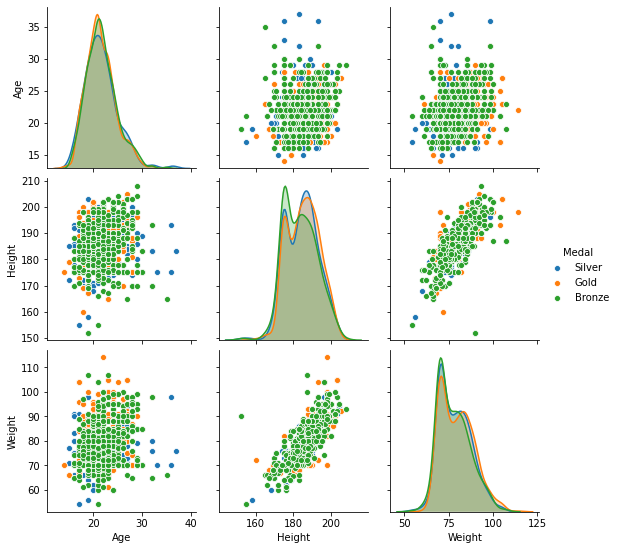

In [13]:
sns.pairplot(swim_train_M[["Age", "Height", "Weight", "Medal"]], hue="Medal")

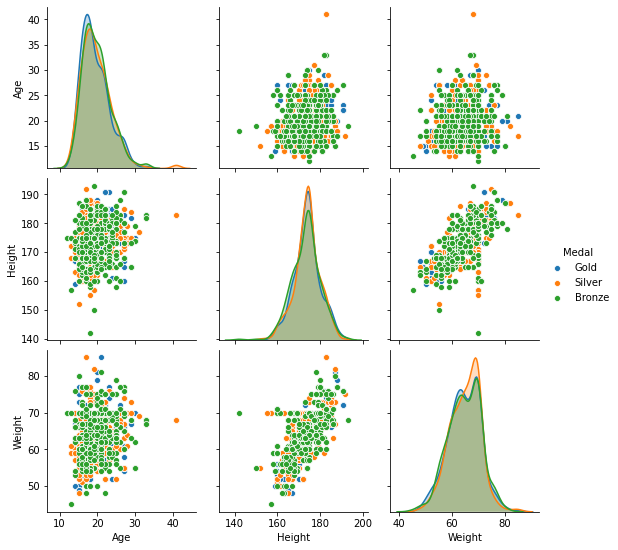

In [14]:
sns.pairplot(swim_train_F[["Age", "Height", "Weight", "Medal"]], hue="Medal")

OBSERVATION: Scatter plots are less dispersed across the x-axis for medal winners vs for those who didn’t win medals, that’s an indication that a correlation between the inputs and output exists and are an important predictor of swimming performance.

BOX PLOT ANALYSIS: Do observe that as the median height increases the probability of winning a gold medal also kind of increases for Male and Female.

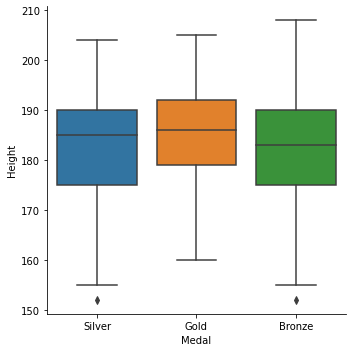

In [15]:
sns.catplot(x="Medal", y="Height", kind="box", data=swim_train_M);

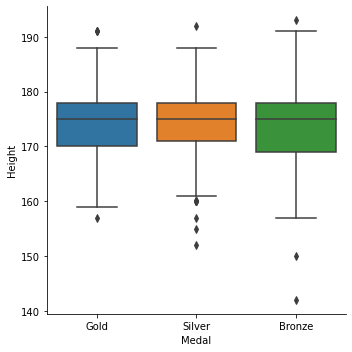

In [16]:
sns.catplot(x="Medal", y="Height", kind="box", data=swim_train_F);

Lets Predict if physical Attributes of Male Swimmers like Age, Height and Weight has any effect on Medal Wins. 

In [17]:
X_train=swim_train_M.loc[:,["Age","Height","Weight","Year"]]
Y_train=swim_train_M['allmedals']

In [18]:
Y_train.value_counts()

0    10901
1     1559
Name: allmedals, dtype: int64

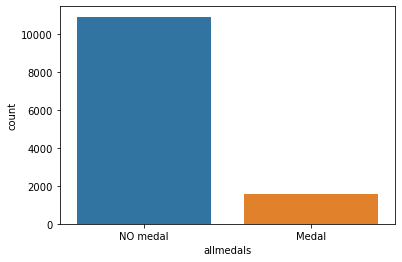

In [19]:
# visualize the target variable
g = sns.countplot(Y_train)
g.set_xticklabels(['NO medal','Medal'])
plt.show()

Observation: IMBALANCED DATASET

FEATURE SELECTION: JUST TO ENSURE ALL THE THREE VARIABLES ARE OF IMPORTANCE.
The SMOTE paper describes that the feature selection should be performed before sampling. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/)

In [20]:
##Feature Selection: RandomForest Classifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=3)
embeded_rf_selector.fit(X_train[['Age','Height', 'Weight']],Y_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train[['Age','Height', 'Weight']].loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

2 selected features
['Height', 'Weight']


In [21]:
##Feature Selection: Recursive Feature Elimination
X_norm = MinMaxScaler().fit_transform(X_train[['Age','Height', 'Weight']])
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=2, step=10, verbose=5)
rfe_selector.fit(X_norm, Y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train[['Age','Height', 'Weight']].loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 3 features.
2 selected features
['Height', 'Weight']


Lets Balance the Dataset using the Hybrid technique - SMOTE + TOMEK Links (Oversampling and undersampling techniques)

In [22]:
#Hybridization: SMOTE + TOMEK Links (Oversampling and undersampling techniques)
from imblearn.combine import SMOTETomek
smtom = SMOTETomek(random_state = 139)
X_train_smtom, Y_train_smtom = smtom.fit_resample(X_train[['Age','Height', 'Weight','Year']],Y_train)
print('Original dataset shape', collections.Counter(Y_train))
print('Resample dataset shape', collections.Counter(Y_train_smtom))

Original dataset shape Counter({0: 10901, 1: 1559})
Resample dataset shape Counter({1: 10848, 0: 10848})


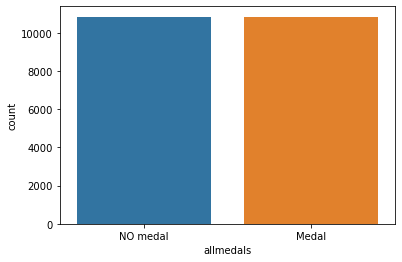

In [23]:
# visualize the target variable after SMOTETomek
g = sns.countplot(Y_train_smtom)
g.set_xticklabels(['NO medal','Medal'])
plt.show()

BUILDING THE MODEL

In [24]:
# Create Random Forest Classifier object
clf = RandomForestClassifier(max_depth=2, random_state=10)

# Create logistic regression object
logreg = LogisticRegression(random_state=10)


Creating a year list to apply timeseries cross validation on the data

In [25]:
year_list = swim_data['Year'].unique()
print(year_list)


[1896 1900 1904 1908 1912 1920 1924 1928 1932 1936 1948 1952 1956 1960
 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008 2012]


In [26]:
## assessing performance of the model using timeseries cross validation
# considering f1 scores 
tscv=TimeSeriesSplit(n_splits=10,max_train_size=None,test_size=2).split(year_list)
tscv1=TimeSeriesSplit(n_splits=10,max_train_size=None,test_size=2).split(year_list)
scores_clf =cross_val_score(clf,X_train_smtom[['Height', 'Weight','Year']],Y_train_smtom, cv=tscv)
scores_logreg = cross_val_score(logreg, X_train_smtom[['Height', 'Weight','Year']], Y_train_smtom, cv=tscv1)

In [27]:
# average performance across all folds
print("Average Accuracy of random forest model across the folds: %0.2f" % (scores_clf.mean()))
print("Average Accuracy of logistic regression model across the folds: %0.2f" % (scores_logreg.mean()))

Average Accuracy of random forest model across the folds: 0.60
Average Accuracy of logistic regression model across the folds: 0.55


In [28]:
#Fitting
clf.fit(X_train_smtom[['Height', 'Weight','Year']], Y_train_smtom)
logreg.fit(X_train_smtom[['Height', 'Weight','Year']], Y_train_smtom)

LogisticRegression(random_state=10)

LETS PREPARE THE TEST DATA BEFORE PREDICTION. 
1)creating the column 'allmedals' using get_dummies method
2) filtering only the swimdata for Males
3) droping any na values


In [29]:
# # Preparing the Test data for prediction :
#lets create separate columns for gold,silver and bronnze using get_dummies method and add new column 'all medals', to represnt if any medal is won or not
new_data_test = pd.concat([data_test,pd.get_dummies(data_test.Medal)],axis=1)
new_data_test['allmedals']= new_data_test['Bronze']+new_data_test['Gold']+new_data_test['Silver']
new_data_test.info()

# filtering swimming data
swim_data_test = new_data_test[new_data_test.Sport=='Swimming']
swim_data_test_M= swim_data_test[swim_data_test.Sex=='M']

# creating a new data frame with the required features.
swim_test_M = swim_data_test_M[["Height","Weight","allmedals","Year"]]
swim_test_M.info()

#droping the NA values
swim_test_M = swim_test_M.dropna()
swim_test_M.info()

# creating the predictors and Target 
X_test = swim_test_M.loc[:,["Height","Weight","Year"]]
Y_test = swim_test_M['allmedals']
print (X_test,Y_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13688 entries, 80 to 271110
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       13688 non-null  object 
 1   Sex        13688 non-null  object 
 2   Age        13688 non-null  float64
 3   Height     13512 non-null  float64
 4   Weight     13465 non-null  float64
 5   Team       13688 non-null  object 
 6   NOC        13688 non-null  object 
 7   Year       13688 non-null  int64  
 8   Season     13688 non-null  object 
 9   City       13688 non-null  object 
 10  Sport      13688 non-null  object 
 11  Event      13688 non-null  object 
 12  Medal      2023 non-null   object 
 13  region     13643 non-null  object 
 14  Bronze     13688 non-null  uint8  
 15  Gold       13688 non-null  uint8  
 16  Silver     13688 non-null  uint8  
 17  allmedals  13688 non-null  uint8  
dtypes: float64(3), int64(1), object(10), uint8(4)
memory usage: 1.6+ MB
<class 'pandas.c

In [30]:
# Make predictions using the testing set
# 1.Random Forest Classifier
y_pred_test = clf.predict(X_test)
print("accuracy of the predictions using random forest:", metrics.accuracy_score(Y_test, y_pred_test))
print("blanced accuracy of the predictions using random forest:", metrics.balanced_accuracy_score(Y_test, y_pred_test))
print("roc_auc accuracy of the predictions using random forest:", metrics.roc_auc_score(Y_test, y_pred_test))
print("recall of the predictions using random forest:", metrics.f1_score(Y_test, y_pred_test, average='macro'))

accuracy of the predictions using random forest: 0.5191326530612245
blanced accuracy of the predictions using random forest: 0.5736660286634611
roc_auc accuracy of the predictions using random forest: 0.5736660286634612
recall of the predictions using random forest: 0.4447206112491945


In [31]:
print(classification_report(Y_test,  y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.50      0.65       691
           1       0.15      0.65      0.24        93

    accuracy                           0.52       784
   macro avg       0.53      0.57      0.44       784
weighted avg       0.82      0.52      0.60       784



In [32]:
print(confusion_matrix(Y_test, y_pred_test))

[[347 344]
 [ 33  60]]


In [33]:
#Logistic Regression

y_pred_test_logreg = logreg.predict(X_test)


print("accuracy of the predictions using logistic regression:", metrics.accuracy_score(Y_test, y_pred_test_logreg))
print("blanced accuracy of the predictions using logistic regression:", metrics.balanced_accuracy_score(Y_test, y_pred_test_logreg))
print("roc_auc accuracy of the predictions using logistic regression:", metrics.roc_auc_score(Y_test, y_pred_test_logreg))
print("recall of the predictions using logistic regression:", metrics.f1_score(Y_test, y_pred_test_logreg, average='macro'))

accuracy of the predictions using logistic regression: 0.48214285714285715
blanced accuracy of the predictions using logistic regression: 0.5619874577906416
roc_auc accuracy of the predictions using logistic regression: 0.5619874577906416
recall of the predictions using logistic regression: 0.42141273130475876


In [34]:
print(classification_report(Y_test,  y_pred_test_logreg))

              precision    recall  f1-score   support

           0       0.91      0.46      0.61       691
           1       0.14      0.67      0.23        93

    accuracy                           0.48       784
   macro avg       0.53      0.56      0.42       784
weighted avg       0.82      0.48      0.56       784



In [35]:
print(confusion_matrix(Y_test, y_pred_test_logreg))

[[316 375]
 [ 31  62]]


BUILD THE GRID OPTIMIZATION MODEL TO SEE IF ACCURACY INCREASES

In [36]:
clf1 = RandomForestClassifier(max_depth=2, random_state=0)

param_grid = {
                 'n_estimators': [5, 10, 15, 20],
                 'max_depth': [2, 5, 7, 9]
             }

tscv3=TimeSeriesSplit(n_splits=12,max_train_size=None,test_size=2).split(year_list)
grid_clf = GridSearchCV(clf1, param_grid, cv=tscv3)
grid_clf.fit(X_train_smtom[['Height', 'Weight','Year']],Y_train_smtom)

#Accuracy of the Score
print(grid_clf)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f52cc0e86d0>,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             param_grid={'max_depth': [2, 5, 7, 9],
                         'n_estimators': [5, 10, 15, 20]})


In [37]:
##Prediction
y_predictions = grid_clf.predict(X_test)
print(y_predictions)

[0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0
 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1
 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1
 1 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1
 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1
 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [38]:
print("accuracy of the predictions using GRIDSEARCH CLF:", metrics.accuracy_score(Y_test, y_predictions))
print("blanced accuracy of the predictions using GRIDSEARCH CLF:", metrics.balanced_accuracy_score(Y_test, y_predictions))
print("roc_auc accuracy of the predictions using GRIDSEARCH CLF:", metrics.roc_auc_score(Y_test, y_predictions))
print("recall of the predictions using GRIDSEARCH CLF:", metrics.f1_score(Y_test, y_predictions, average='macro'))

accuracy of the predictions using GRIDSEARCH CLF: 0.6058673469387755
blanced accuracy of the predictions using GRIDSEARCH CLF: 0.5949535502544232
roc_auc accuracy of the predictions using GRIDSEARCH CLF: 0.5949535502544232
recall of the predictions using GRIDSEARCH CLF: 0.49526529948933995


In [39]:
print(confusion_matrix(Y_test, y_predictions))

[[421 270]
 [ 39  54]]


OBSERVATION: The performance of GRID Search Optimized Classifier is found better. This Needs more better Results description Which I would be doing at the End.

TO DO: to better explain my findings:
classification accuracy = correct predictions / total predictions * 100
error rate = (1 - (correct predictions / total predictions)) * 100